In [1]:
import numpy as np
import pandas as pd
import cPickle
import multiprocessing
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

### Reading tweets

In [2]:
bank_train = pd.read_csv('../data/bank_train.csv', sep='\t', encoding='utf-8')

In [3]:
bank_train.head()

,id,text,label
0,1,http://t.co/YEVHuvVGA1 Взять кредит тюмень аль...,0
1,2,Мнение о кредитной карте втб 24 http://t.co/SB...,0
2,3,«Райффайзенбанк»: Снижение ключевой ставки ЦБ ...,0
3,4,Современное состояние кредитного поведения в р...,0
4,5,@sawik_shuster @YevhenS Главное чтоб банки СБЕ...,1


In [4]:
texts, labels = bank_train.text.values, bank_train.label.values

### Reading vocabulary and embeddings

In [5]:
word2id, embeddings = cPickle.load(open('../data/w2v/vectors_l.pkl', 'rb'))
# word2id, embeddings = cPickle.load(open('../data/w2v/parkin_vectors.pkl', 'rb'))

In [6]:
vocabulary = word2id.keys()
eos_id = word2id[u'</s>']

### Lemmatizing and replacing words with ids

In [7]:
from nltk.tokenize import RegexpTokenizer
import pymorphy2

tokenizer = RegexpTokenizer(u'[а-яА-Я]+')
morph = pymorphy2.MorphAnalyzer()

def text2seq(text):
    tokens_norm = [morph.parse(w)[0].normal_form for w in tokenizer.tokenize(text)]
    return [word2id[w] for w in tokens_norm if w in vocabulary] + [eos_id]

sample = texts[49]

print sample
print u' '.join(tokenizer.tokenize(sample))
print u' '.join([morph.parse(w)[0].normal_form for w in tokenizer.tokenize(sample)])
print text2seq(sample)

http://t.co/14dY9LVVeV Взять кредит на технику в альфа банке
Взять кредит на технику в альфа банке
взять кредит на техника в альфа банка
[218, 992, 5, 1032, 2, 6915, 979, 0]


Dumping

Loading

In [8]:
X = cPickle.load(open('../data/X_bank_train_full.pkl', 'rb'))

Distribution of sequences' lengths 

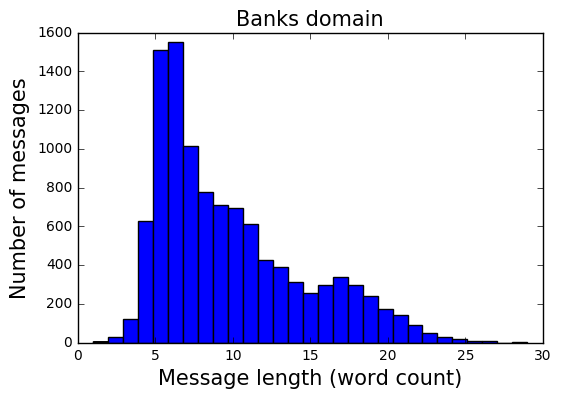

In [9]:
length_max = max(map(len, X))
plt.hist(map(len, X), bins=length_max)
plt.title("Banks domain", fontsize=15)
plt.xlabel("Message length (word count)", fontsize=15)
plt.ylabel("Number of messages", fontsize=15)
plt.show()

### Zero padding

In [10]:
X = [x + [eos_id]*(length_max - len(x)) for x in X]

### Examples

In [11]:
for x in X[:4]:
    print x

[218, 992, 10694, 6915, 1730, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[192, 26, 5239, 1196, 10418, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[67959, 2767, 2520, 1918, 2234, 5, 2306, 2, 29, 3832, 76, 10158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[544, 627, 5239, 1297, 2, 32, 5599, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### One-hot encode labels

In [12]:
X = np.array(X)
y = bank_train.label.values

In [13]:
def cls2probs(cls):
    if cls == -1:
        return [1., 0., 0.]
    elif cls == 0:
        return [0., 1., 0.]
    else:
        return [0., 0., 1.]

y = np.array([cls2probs(cls) for cls in y])

### Split into train and validation sets

In [14]:
from sklearn.model_selection import train_test_split

VAL_SIZE = 0.1

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=VAL_SIZE, random_state=40)

In [15]:
print "Train class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_tr.transpose()]
print "Validation class frequencies:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()]
print "Constant classifier's validation accuracy:\t", [col.nonzero()[0].shape[0] for col in y_val.transpose()][1] * 1. / y_val.shape[0]

Train class frequencies:	[2517, 6449, 686]
Validation class frequencies:	[290, 709, 74]
Constant classifier's validation accuracy:	0.660764212488


### Resampling

---

# Network learning

In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import LSTMCell, GRUCell
from tensorflow.python.ops.rnn import bidirectional_dynamic_rnn as bi_rnn
from tensorflow.contrib.layers import fully_connected

from utils import *

In [20]:
y_pred_major = np.zeros(y_val.shape)
y_pred_major[:,0] = 1.
print "Constant classifier's F-score on validation set:", f_macro(y_val, y_pred_major)

Constant classifier's F-score on validation set: 0.212765957447


### Bi-RNN

In [21]:
EMBED_DIM = 300
HIDDEN_SIZE = 50
NUM_CLASSES = 3

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, None])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)
batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)
    
# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(2, outputs)
# outputs2,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs2 = tf.concat(2, outputs2)

# Last output of Bi-RNN
output = outputs[:,0,:]

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [22]:
# Adam parameters
LEARNING_RATE = 1e-4
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat, target_ph), name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
                                   epsilon=EPSILON).minimize(loss)
# optimizer = tf.train.MomentumOptimizer(learning_rate=1e-1, momentum=0.1).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 99
	 Train loss: 0.177	 ce: 0.177	 acc: 0.941	 f_macro: 0.833
	 Valid loss: 0.275	 ce: 0.275	 acc: 0.896	 f_macro: 0.696


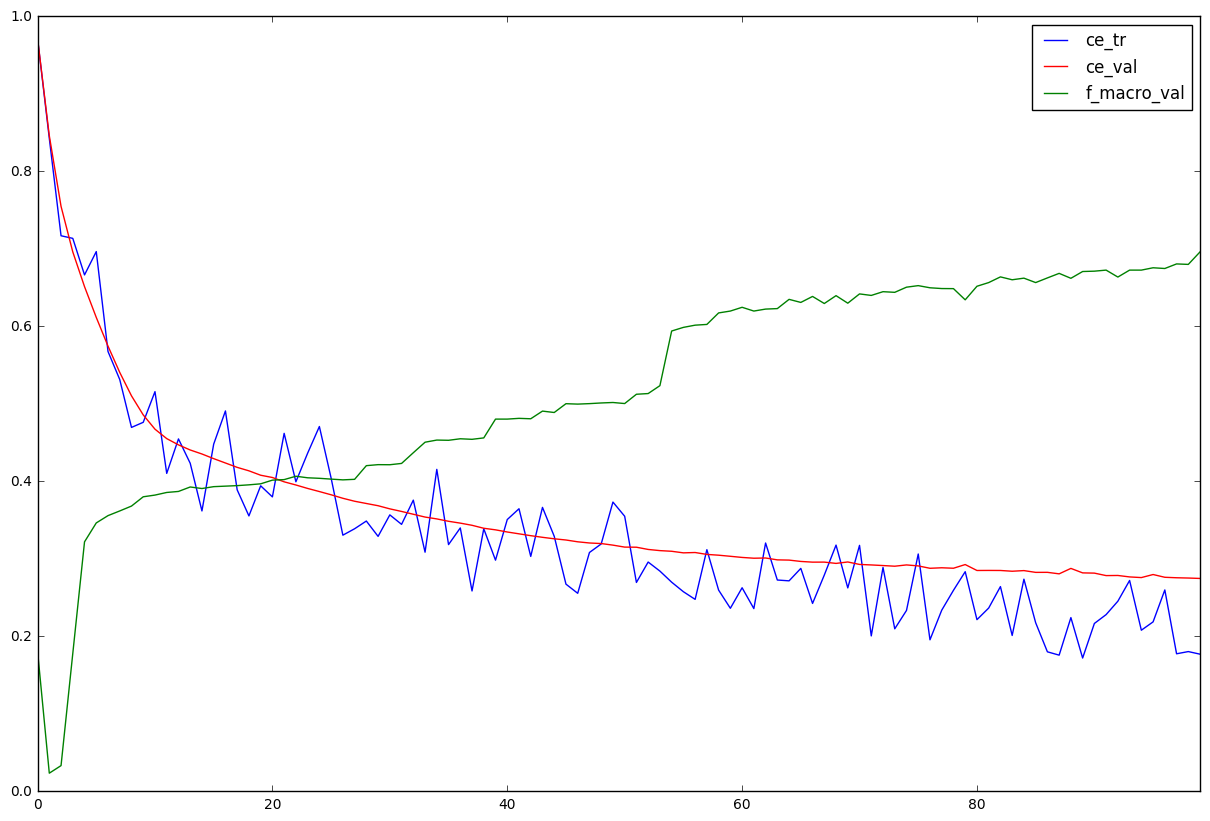

In [23]:
DROPOUT = 0.6  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 100

results = []

train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

loss_tr_l = []
loss_val_l = []
ce_tr_l = []  # Cross-entropy
ce_val_l = []
acc_tr_l = []  # Accuracy
acc_val_l = []
f_macro_tr_l = []
f_macro_val_l = []
f_fair_tr_l = []
f_fair_val_l = []
min_ce = 0.32

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
    print "Start learning..."
    for epoch in range(EPOCHS):
        for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
            x_batch, y_batch = train_batch_generator.next()
            seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
            sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                           seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

        y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                              feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                         seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
        seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
        y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})


        y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
        y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
        f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
        f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)

        loss_tr_l.append(loss_tr)
        loss_val_l.append(loss_val)
        ce_tr_l.append(ce_tr)
        ce_val_l.append(ce_val)
        acc_tr_l.append(acc_tr)
        acc_val_l.append(acc_val)
        f_macro_tr_l.append(f_macro_tr)
        f_macro_val_l.append(f_macro_val)

        clear_output(wait=True)
        print "epoch: {}".format(epoch)
        print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_tr, ce_tr, acc_tr, f_macro_tr)
        print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
            loss_val, ce_val, acc_val, f_macro_val)

        plt.figure(figsize=(15,10))
        plt.plot(ce_tr_l, color='blue', label='ce_tr')
        plt.plot(ce_val_l, color='red', label='ce_val')        
        plt.plot(f_macro_val_l, color='green', label='f_macro_val')
        plt.xlim(0, EPOCHS - 1)
        plt.ylim(0, 1)
        plt.legend()
        plt.show()

    saver = tf.train.Saver() 
    saver.save(sess, 'model_birnn')

results.append([acc_val_l[-1], f_macro_val_l[-1]])

### Cross-validation

epoch: 1
	 Train loss: 0.579	 ce: 0.579	 acc: 0.793	 f_macro: 0.352
	 Valid loss: 0.528	 ce: 0.528	 acc: 0.818	 f_macro: 0.363


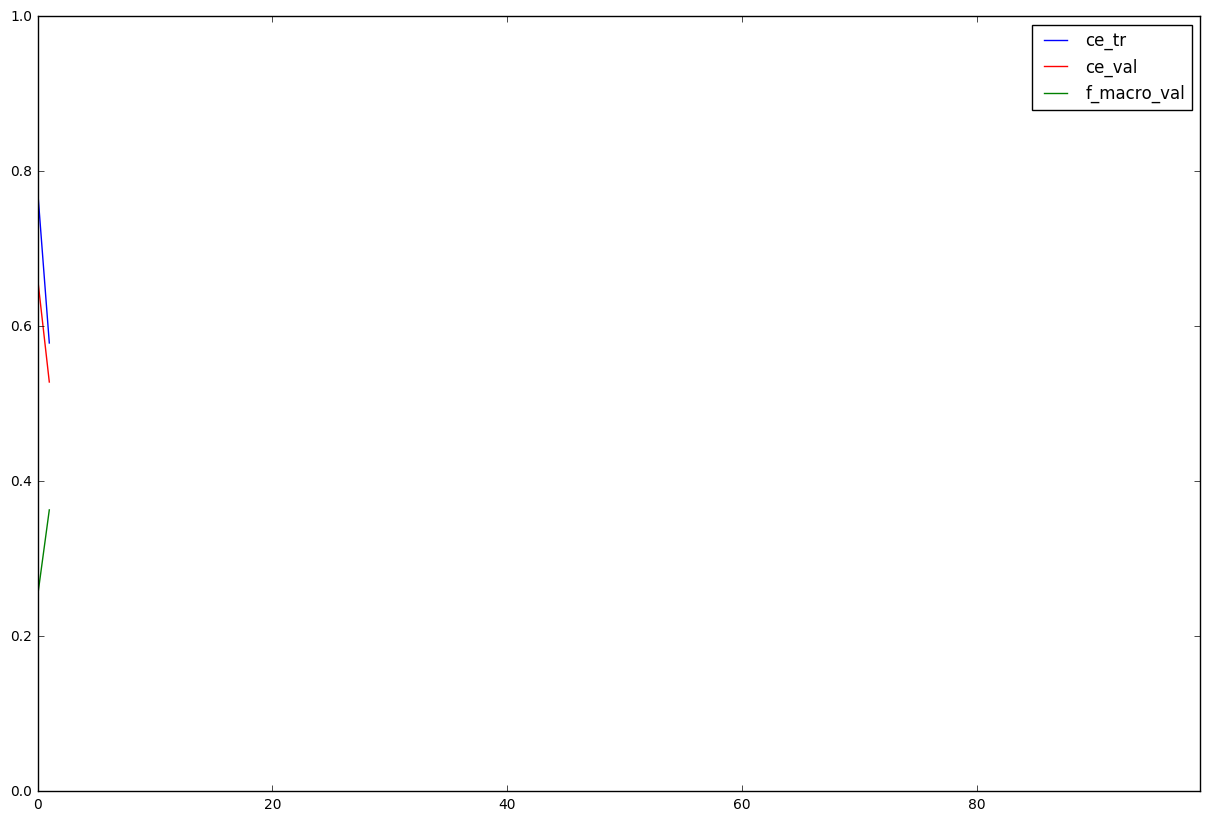

KeyboardInterrupt: 

In [26]:
from sklearn.model_selection import StratifiedKFold, KFold

DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 100

skf = KFold(10, shuffle=True, random_state=42)

results = []

for train_index, test_index in skf.split(X, y):
    X_tr, X_val = X[train_index], X[test_index]
    y_tr, y_val = y[train_index], y[test_index]

    train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

    loss_tr_l = []
    loss_val_l = []
    ce_tr_l = []  # Cross-entropy
    ce_val_l = []
    acc_tr_l = []  # Accuracy
    acc_val_l = []
    f_macro_tr_l = []
    f_macro_val_l = []
    f_fair_tr_l = []
    f_fair_val_l = []
    min_ce = 0.32

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
        print "Start learning..."
        for epoch in range(EPOCHS):
            for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
                x_batch, y_batch = train_batch_generator.next()
                seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
                sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                               seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

            y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                  feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                             seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
            seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
            y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                             feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                        seq_len_ph: seq_len_val, keep_prob_ph: 1.0})


            y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
            y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
            f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
            f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)

            loss_tr_l.append(loss_tr)
            loss_val_l.append(loss_val)
            ce_tr_l.append(ce_tr)
            ce_val_l.append(ce_val)
            acc_tr_l.append(acc_tr)
            acc_val_l.append(acc_val)
            f_macro_tr_l.append(f_macro_tr)
            f_macro_val_l.append(f_macro_val)

            clear_output(wait=True)
            print "epoch: {}".format(epoch)
            print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_tr, ce_tr, acc_tr, f_macro_tr)
            print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_val, ce_val, acc_val, f_macro_val)

            plt.figure(figsize=(15,10))
            plt.plot(ce_tr_l, color='blue', label='ce_tr')
            plt.plot(ce_val_l, color='red', label='ce_val')        
            plt.plot(f_macro_val_l, color='green', label='f_macro_val')
            plt.xlim(0, EPOCHS - 1)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
    results.append([acc_val_l[-1], f_macro_val_l[-1]])

In [142]:
min(ce_val_l), max(acc_val_l), max(f_macro_val_l)

(0.28313833, 0.91235435, 0.756499969837727)

---

### Bi-RNN with Attention mechanism

Attention mechanism formulas and notation
$$
\upsilon_{t}=\tanh{(W_{\omega}\left[\overrightarrow{h_{t}},\overleftarrow{h_{t}}\right]+b_{\omega})}\\
\alpha_{t}=\frac{\exp{(\upsilon_{t}^{T}u_{\omega})}}{\sum_{j=1}^{T}\exp{(\upsilon_{j}^{T}u_{\omega})}}\\
\upsilon=\sum_{t=1}^{T}\alpha_{t}h_{t}	
$$

In [21]:
EMBED_DIM = 300
SEQ_LENGTH = length_max
HIDDEN_SIZE = 100
ATTENTION_SIZE = 100
NUM_CLASSES = 3

tf.reset_default_graph()

batch_ph   = tf.placeholder(tf.int32, [None, SEQ_LENGTH])
target_ph  = tf.placeholder(tf.float32, [None, NUM_CLASSES])
seq_len_ph = tf.placeholder(tf.int32, [None])
keep_prob_ph = tf.placeholder(tf.float32)

embeddings_ph = tf.placeholder(tf.float32, [len(vocabulary), EMBED_DIM])
embeddings_var = tf.Variable(tf.constant(0., shape=[len(vocabulary), EMBED_DIM]), trainable=False)
init_embeddings = embeddings_var.assign(embeddings_ph)

batch_embedded = tf.nn.embedding_lookup(embeddings_var, batch_ph)

# Bi-RNN layers
outputs,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
                   inputs=batch_embedded,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn1")  
outputs = tf.concat(2, outputs)
# outputs2,_ = bi_rnn(GRUCell(HIDDEN_SIZE), GRUCell(HIDDEN_SIZE),
#                          inputs=outputs,sequence_length=seq_len_ph, dtype=tf.float32, scope="bi_rnn2")
# outputs2 = tf.concat(2, outputs2)

# Attention mechanism
W_omega = tf.Variable(tf.random_normal([2 * HIDDEN_SIZE, ATTENTION_SIZE], stddev=0.1))
b_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))
u_omega = tf.Variable(tf.random_normal([ATTENTION_SIZE], stddev=0.1))

v = tf.tanh(tf.matmul(tf.reshape(outputs, [-1, 2 * HIDDEN_SIZE]), W_omega) + tf.reshape(b_omega, [1, -1]))
vu = tf.matmul(v, tf.reshape(u_omega, [-1, 1]))
exps = tf.reshape(tf.exp(vu), [-1, SEQ_LENGTH])
alphas = exps / tf.reshape(tf.reduce_sum(exps, 1), [-1, 1])

# Output of Bi-RNN is reduced with attention vector
output = tf.reduce_sum(outputs * tf.reshape(alphas, [-1, SEQ_LENGTH, 1]), 1)

# Dropout
drop = tf.nn.dropout(output, keep_prob_ph)

# Fully connected layer
W = tf.Variable(tf.truncated_normal([HIDDEN_SIZE * 2, NUM_CLASSES], stddev=0.1), name="W")
b = tf.Variable(tf.constant(0., shape=[NUM_CLASSES]), name="b")
y_hat = tf.nn.xw_plus_b(drop, W, b, name="scores")

In [22]:
# Adam parameters
LEARNING_RATE = 1e-4
EPSILON = 1e-5
BETA1 = 0.9
BETA2 = 0.9
# L2 regularization coefficient
BETA = 0

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_hat, target_ph), name="cross_entropy")
l2_loss = tf.nn.l2_loss(W, name="l2_loss")
loss = cross_entropy + l2_loss * BETA
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2,
                                   epsilon=EPSILON).minimize(loss)
# optimizer = tf.train.AdadeltaOptimizer(learning_rate=LEARNING_RATE, rho=0.7).minimize(loss)
# optimizer = tf.train.AdagradOptimizer(learning_rate=LEARNING_RATE, initial_accumulator_value=0.1).minimize(loss)
# optimizer = tf.train.MomentumOptimizer(learning_rate=1e-1, momentum=0.1).minimize(loss)
# optimizer = tf.train.RMSPropOptimizer(learning_rate=LEARNING_RATE, decay=0.9, momentum=0.1).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(target_ph, 1), tf.argmax(y_hat, 1)), tf.float32))

epoch: 99
	 Train loss: 0.126	 ce: 0.126	 acc: 0.949	 f_macro: 0.865
	 Valid loss: 0.433	 ce: 0.433	 acc: 0.872	 f_macro: 0.719


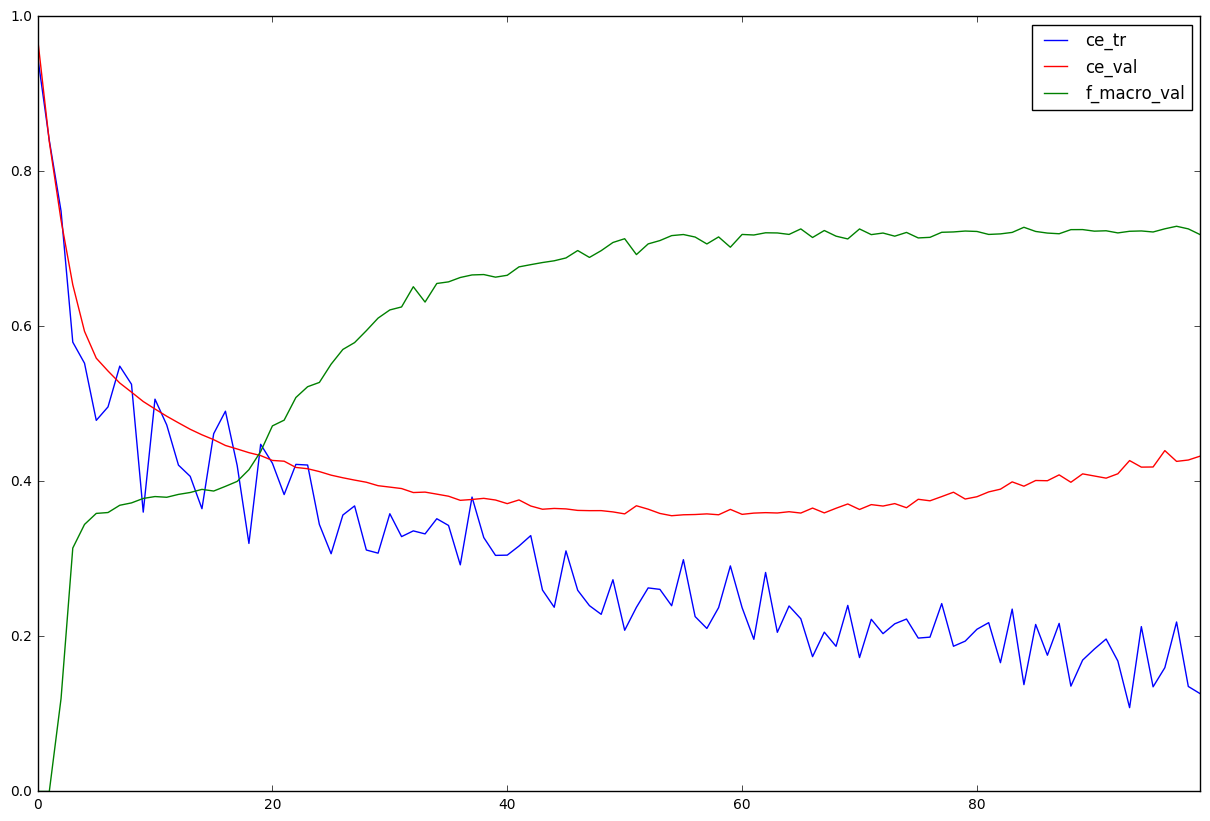

In [39]:
from sklearn.model_selection import StratifiedKFold, KFold

DROPOUT = 0.5  # Probability of keeping a neuron
BATCH_SIZE = 256
EPOCHS = 100

results = []
results50 = []


skf = KFold(5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X, y):
    X_tr, X_val = X_full[train_index], X_full[test_index]
    y_tr, y_val = y_full[train_index], y_full[test_index]
    train_batch_generator = batch_generator(X_tr, y_tr, BATCH_SIZE)

    loss_tr_l = []
    loss_val_l = []
    ce_tr_l = []  # Cross-entropy
    ce_val_l = []
    acc_tr_l = []  # Accuracy
    acc_val_l = []
    f_macro_tr_l = []
    f_macro_val_l = []
    f_fair_tr_l = []
    f_fair_val_l = []

    min_ce = 0.3

    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        sess.run(init_embeddings, feed_dict={embeddings_ph: embeddings})
        print "Start learning..."
        for epoch in range(EPOCHS):
            for i in range(int(X_tr.shape[0] / BATCH_SIZE)):
                x_batch, y_batch = train_batch_generator.next()
                seq_len_tr = np.array([list(x).index(eos_id) + 1 for x in x_batch])
                sess.run(optimizer, feed_dict={batch_ph: x_batch, target_ph: y_batch,
                                               seq_len_ph: seq_len_tr, keep_prob_ph: DROPOUT})

            y_pred_tr, ce_tr, loss_tr, acc_tr = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                  feed_dict={batch_ph: x_batch, target_ph: y_batch, 
                                                             seq_len_ph: seq_len_tr, keep_prob_ph: 1.0})
            seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
            y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                             feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                        seq_len_ph: seq_len_val, keep_prob_ph: 1.0})


            y_pred_tr = np.array([cls2probs(cls) for cls in np.argmax(y_pred_tr, 1) - 1])
            y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
            f_macro_tr, f_micro_tr = f_macro(y_batch, y_pred_tr), f_micro(y_batch, y_pred_tr)
            f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)

            loss_tr_l.append(loss_tr)
            loss_val_l.append(loss_val)
            ce_tr_l.append(ce_tr)
            ce_val_l.append(ce_val)
            acc_tr_l.append(acc_tr)
            acc_val_l.append(acc_val)
            f_macro_tr_l.append(f_macro_tr)
            f_macro_val_l.append(f_macro_val)

            clear_output(wait=True)
            print "epoch: {}".format(epoch)
            print "\t Train loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_tr, ce_tr, acc_tr, f_macro_tr)
            print "\t Valid loss: {:.3f}\t ce: {:.3f}\t acc: {:.3f}\t f_macro: {:.3f}".format(
                loss_val, ce_val, acc_val, f_macro_val)

            plt.figure(figsize=(15,10))
            plt.plot(ce_tr_l, color='blue', label='ce_tr')
            plt.plot(ce_val_l, color='red', label='ce_val')        
            plt.plot(f_macro_val_l, color='green', label='f_macro_val')
            plt.xlim(0, EPOCHS - 1)
            plt.ylim(0, 1)
            plt.legend()
            plt.show()
            
            if epoch == 49:
                results50.append([acc_val_l[-1], f_macro_val_l[-1]])
    results.append([acc_val_l[-1], f_macro_val_l[-1]])

    #         if ce_val < min_ce:
    #             min_ce = ce_val
#         saver = tf.train.Saver() 
#         saver.save(sess, 'model_attention_momentum')

In [324]:
min(ce_val_l), max(acc_val_l), max(f_macro_val_l)

(0.24238382, 0.92178774, 0.8276723276723278)

---

---

---

# Testing

In [24]:
bank_test = pd.read_csv('../data/bank_test.csv', sep='\t', encoding='utf-8')
texts_test, labels_test = bank_test.text.values, bank_test.label.values

In [25]:
X_test = cPickle.load(open('../data/X_bank_test.pkl', 'rb'))

In [26]:
X_test = [x + [eos_id]*(length_max - len(x)) for x in X_test]
X_test = np.array(X_test)
y_test = np.array([cls2probs(cls) for cls in labels_test])

In [27]:
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('model_birnn.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./'))
    
    seq_len_test = np.array([list(x).index(eos_id) + 1 for x in X_test])
    y_pred_test, ce_test, loss_test, acc_test = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                     feed_dict={batch_ph: X_test, target_ph: y_test,
                                                                seq_len_ph: seq_len_test, keep_prob_ph: 1.0})
    seq_len_val = np.array([list(x).index(eos_id) + 1 for x in X_val])
    y_pred_val, ce_val, loss_val, acc_val = sess.run([y_hat, cross_entropy, loss, accuracy],
                                                         feed_dict={batch_ph: X_val, target_ph: y_val,
                                                                    seq_len_ph: seq_len_val, keep_prob_ph: 1.0})

In [28]:
y_pred_val = np.array([cls2probs(cls) for cls in np.argmax(y_pred_val, 1) - 1])
f_macro_val, f_micro_val = f_macro(y_val, y_pred_val), f_micro(y_val, y_pred_val)
print f_macro_val, f_micro_val

0.696234483578 0.820874471086


In [29]:
y_pred_test = np.array([cls2probs(cls) for cls in np.argmax(y_pred_test, 1) - 1])
f_macro_test, f_micro_test = f_macro(y_test, y_pred_test), f_micro(y_test, y_pred_test)
print f_macro_test, f_micro_test

0.453776299464 0.49931787176


Varying hidden size.

In [30]:
# bi-rnn, hid 20
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.467922401996 0.75 0.863933
0.34037092883 0.478134110787 0.711235


In [30]:
# bi-rnn, hid 50
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.699525027402 0.819718309859 0.892824
0.478858411929 0.518889394629 0.714745


In [30]:
# bi-rnn, hid 100
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.74680292623 0.830680173661 0.901212
0.47275190571 0.48440545809 0.714453


In [34]:
# bi-rnn, hid 200
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.745623722362 0.831275720165 0.899348
0.489717224781 0.513651877133 0.700702


In [30]:
# bi-rnn, hid 300
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.7697489784 0.837725381415 0.904939
0.463680528874 0.493424036281 0.706554


In [30]:
# bi-rnn, hid 450
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.776952683764 0.843373493976 0.904007
0.455681266844 0.483305509182 0.679052


Varying dropout parameter.

In [30]:
# bi-rnn, hid 50, keep_prob 0.1
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.464387464387 0.761904761905 0.870457
0.295693999084 0.453077699294 0.708601


In [30]:
# bi-rnn, hid 50, keep_prob 0.2
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.637287311619 0.797736916549 0.885368
0.423044459565 0.501831501832 0.709187


In [30]:
# bi-rnn, hid 50, keep_prob 0.3
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.643780518575 0.802228412256 0.885368
0.417797184151 0.493039964077 0.697191


In [30]:
# bi-rnn, hid 50, keep_prob 0.4
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.648329480365 0.801120448179 0.884436
0.450942742614 0.501098901099 0.703335


In [30]:
# bi-rnn, hid 50, keep_prob 0.6
print f_macro_val, f_micro_val, acc_val
print f_macro_test, f_micro_test, acc_test

0.696234483578 0.820874471086 0.89562
0.453776299464 0.49931787176 0.708309
